In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import re
import math
from datetime import datetime
import importlib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report;
import time

from sklearn.feature_selection import RFE
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.model_selection import learning_curve, GridSearchCV

In [2]:
from autoscoring import IDF
from autoscoring.AS import *
from autoscoring.AS_2 import *
from autoscoring.Binning import transform_df_to_woe, construction_binning, correct_binning_dict, print_feature_bins

In [ ]:
# !pip install lightgbm

In [3]:
df = pd.read_excel('data/slkz_SolvaStreet.xlsx', sheet_name='result 1')

# Добавить, если имя целевой переменной отличается от 'target'
# df['target'] = 

df['date_requested'] = pd.to_datetime(df['date_requested'])
date_name = 'date_requested'  # Дата, по которой аггрегировать и оценивать gini/psi и т.д. по дефолту дата выдачи.
df_req = df[['credit_id', date_name]]
df['y'] = df['target']
y = df.y

In [4]:
# Удаляем лишние колонки, конкретный набор зависит от сэмпла.
cols_to_drop = [var for var in df.columns if 'SCORE' in var or 'scoring' in var or 'street' in var]
df.drop(cols_to_drop, axis=1, inplace=True)

In [5]:
# Filling missing values (np.nan, '_MISSING_')
cat_vars = df.select_dtypes(include=[object]).columns
df = filling(df)

min_num = 50
df, else_df = replace_not_frequent_2(df, cat_vars, num_min = min_num)

# Drop columns with only 1 value
df = drop_single_value_column(df)

In [6]:
# Если вы не разделяете сэмпл на df_out, то можете закомментировать этот кусок,
# и вместо него запустить:
# df_out, y_out = None, None

df_out = df[df['date_requested'] >= '2021-01-01']
df = df[df['date_requested'] < '2021-01-01']
y_out = df_out.y

In [7]:
df_train, df_test, y_train, y_test = train_test_split(df, df.y, test_size=0.2, stratify=df.y, random_state=123)

In [14]:
# Загружаем WOE таблицу для обновленного биннинга.

iv_df = pd.read_excel('result/new_iv_df.xlsx')
vars = iv_df['VAR_NAME'].unique()
vars_woe = 'WOE_' + vars
IV = iv_df[['VAR_NAME', 'IV']].drop_duplicates()

In [15]:
iv_co = None
X_train, y_train = transform_df_to_woe(df_train[vars], y_train, IV, iv_df, iv_cut_off=iv_co)
X_test, y_test = transform_df_to_woe(df_test[vars], y_test, IV, iv_df, iv_cut_off=iv_co)
X_out, y_out = transform_df_to_woe(df_out[vars], y_out, IV, iv_df, iv_cut_off=iv_co)

Features left after IV drop: 8
DONE!
Features left after IV drop: 8
DONE!
Features left after IV drop: 8
DONE!


In [16]:
X_train.columns = 'WOE_' + X_train.columns
X_test.columns = 'WOE_' + X_test.columns
X_out.columns = 'WOE_' + X_out.columns

In [17]:
# Есть возможность удалить объекты с аномальными признаками на этапе обученя, может немного улучшить gini.
# Доля обхектов, которую можно откинуть, следует поэкспериментирова.
# Оптимально - выбирать значения в интервале 0.00 - 0.04
percentile = 0.00
X_train_anom, y_train_anom = anomaly_detection_forest(X_train[vars_woe], y_train, percentile=percentile)

# Если что-то не так, или удаление аномалий не требуется,
# то можно закомментировать верхние строчки и разкомментировать нижнюю.
# X_train_anom, y_train_anom = X_train, y_train

In [33]:
# !pip install optuna
# Можно произвести подбор гиперпараметров логистической регрессии.
best_param = parameter_optimization(X_train, y_train, vars_woe,
                                    {'class_weight_1': [1, 8],'C': [1e-5, 10000]})

In [34]:
best_param

{'penalty': 'l2',
 'class_weight_1': 3.1326583022355705,
 'C': 10.771068801843926}

In [36]:
df_train_m = X_train_anom[vars_woe]
df_test_m = X_test[vars_woe]
df_out_m = X_out[vars_woe]

params = {
    'penalty': 'l2', 'C': 10.7, 'solver': 'liblinear',
    'class_weight': {0: 1, 1: 3.1}, 'random_state': 142
}
# Обучаем модель на данных полученных после удаления аномалий.
logreg = LogisticRegression(**params).fit(df_train_m, y_train_anom)

df_train_m = X_train[vars_woe]
predict_proba_train = logreg.predict_proba(df_train_m)[:, 1]
predict_proba_test = logreg.predict_proba(df_test_m)[:, 1]
predict_proba_out = logreg.predict_proba(df_out_m)[:, 1]

roc_train = roc_auc_score(y_train, predict_proba_train)
roc_test = roc_auc_score(y_test, predict_proba_test)
roc_out = roc_auc_score(y_out, predict_proba_out)

Gini_train = 2*roc_train - 1
Gini_test = 2*roc_test - 1
Gini_out = 2*roc_out - 1
g_train = '{:.3f}'.format(Gini_train)
g_test = '{:.3f}'.format(Gini_test)
g_out = '{:.3f}'.format(Gini_out)

print('---------------------------------------------------------------------------------------------')
print('| Gini train =', g_train, '| Gini test =', g_test,  '| Gini out =', g_out, '|')
print('---------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------
| Gini train = 0.460 | Gini test = 0.435 | Gini out = 0.432 |
---------------------------------------------------------------------------------------------


Cross_val_scores:  [0.46475242 0.42750681 0.46437779 0.46699423 0.43474423]
ROC_AUC:   0.717
Gini Train: 0.46
Gini Test: 0.435
F1_score:  0.255
Log_loss:  4.618


Classification_report: 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      1537
           1       0.38      0.22      0.28       258

    accuracy                           0.84      1795
   macro avg       0.63      0.58      0.60      1795
weighted avg       0.81      0.84      0.82      1795

[array([-0.69994286, -0.82660488, -0.67977221, -0.28099656, -0.65573176,
       -0.430143  , -0.93526524, -0.72128135]), -0.7645391873581665]


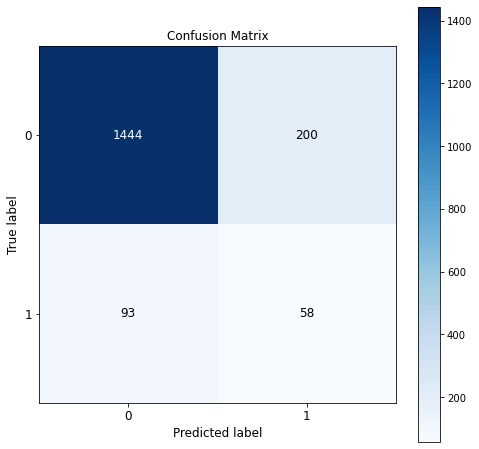

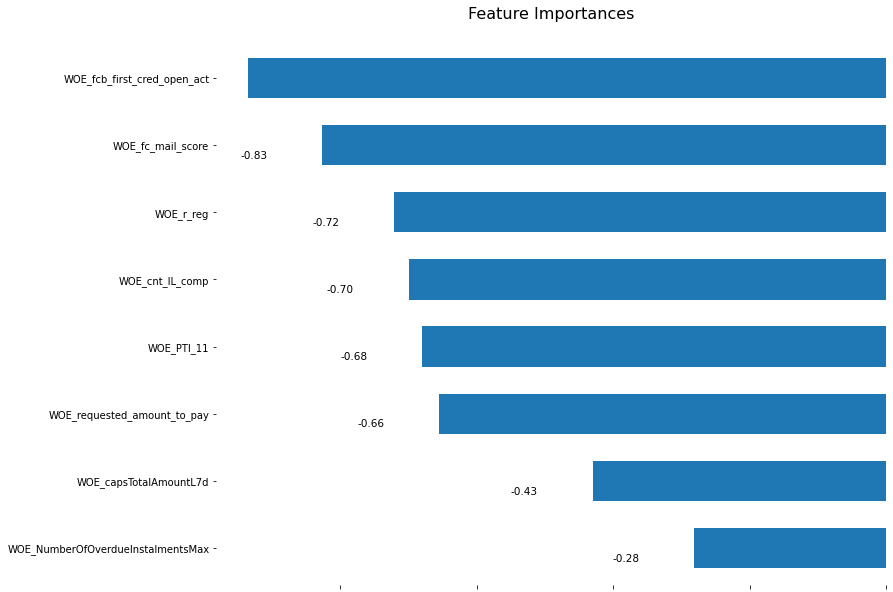

In [19]:
_X = np.vstack([X_train[vars_woe], X_test[vars_woe]])
_y = np.hstack([y_train, y_test])

_logreg = LogisticRegression(**params)
scores = 2*cross_val_score(_logreg, _X, _y, cv=5, scoring='roc_auc')-1
print ('Cross_val_scores: ', scores)

_logreg = logreg
IDF.plot_score(_logreg, X_test[vars_woe], y_test, X_train[vars_woe], y_train, cut_off=0.45)
print([_logreg.coef_[0], _logreg.intercept_[0] ])

In [20]:
date_name = 'date_requested'  # имя столбца даты по которому делить на месяцы
df3, feat = construct_df3(vars_woe, logreg, df_req, X_train, X_test, df_train, df_test, X_out=None, df_out=None, date_name=date_name)

# Pivot table of Score Buckets
table = pd.pivot_table(
    df3,
    index=['requested_month_year'],
    columns=['Score_bucket'],
    values=['Score'],
    aggfunc='count').fillna(0)

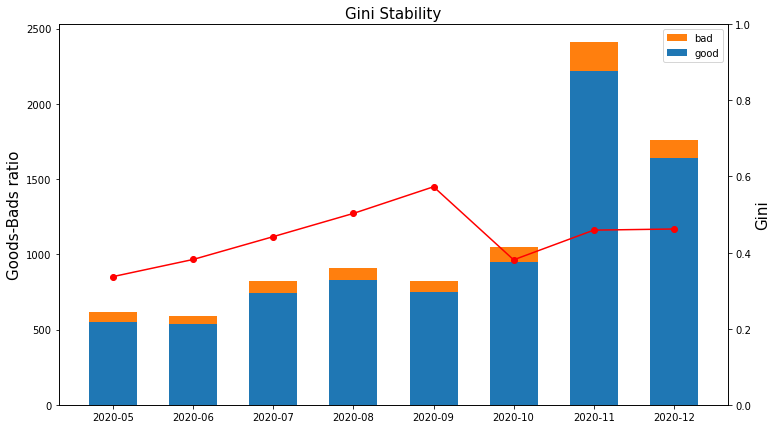

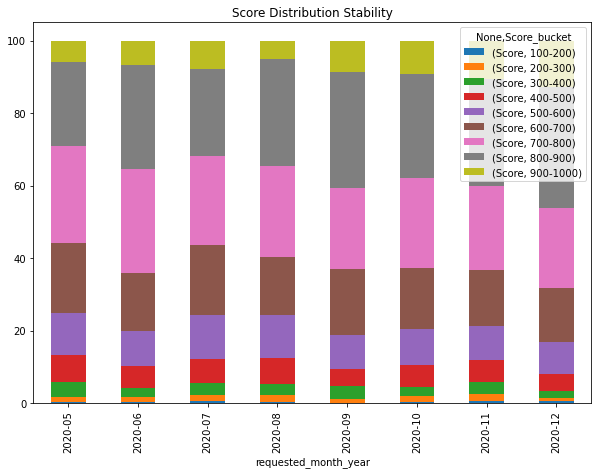

In [21]:
Ginis = create_gini_stability(df3, logreg, X_train[vars_woe])

pic_folder = 'pic/'  # Папка, в которую сохранятся картинки, надо отдельно создать её.
gini_stability_chart(Ginis, pic_folder=pic_folder)
score_stability_graph(table, pic_folder=pic_folder)

In [22]:
# Считаем однофакторный gini для train, test, out.
gini_by_vars = gini_univariate(X_train, X_test, X_out, y_train, y_test, y_out, vars_woe)

In [23]:
gini_by_vars

,vars,gini_train,gini_test,gini_out
0,WOE_cnt_IL_comp,0.267,0.278,0.293
4,WOE_requested_amount_to_pay,0.241,0.187,0.205
5,WOE_capsTotalAmountL7d,0.236,0.203,0.217
2,WOE_PTI_11,0.2,0.153,0.076
3,WOE_NumberOfOverdueInstalmentsMax,0.188,0.197,0.246
7,WOE_r_reg,0.169,0.178,0.273
1,WOE_fc_mail_score,0.161,0.149,0.035
6,WOE_fcb_first_cred_open_act,0.124,0.131,0.158


In [24]:
# Считаем однофакторный gini по месяцам.
date_name = 'date_requested'  # Дата, по которой делить на месяцы.
_, df_gini_months = gini_month_selection(df3[vars_woe], df3, date_name=date_name)

In [25]:
df_gini_months

,vars,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
0,WOE_cnt_IL_comp,0.178,0.074,0.325,0.238,0.306,0.306,0.262,0.346
1,WOE_fc_mail_score,0.113,0.059,0.110,0.148,0.171,0.130,0.180,0.108
2,WOE_PTI_11,0.151,0.139,0.179,0.273,0.345,0.048,0.206,0.159
3,WOE_NumberOfOverdueInstalmentsMax,0.144,0.120,0.189,0.056,0.268,0.170,0.212,0.275
4,WOE_requested_amount_to_pay,0.179,0.267,0.221,0.324,0.324,0.184,0.195,0.189
5,WOE_capsTotalAmountL7d,0.127,0.238,0.213,0.354,0.210,0.183,0.226,0.217
6,WOE_fcb_first_cred_open_act,0.160,0.203,0.096,0.136,0.092,0.114,0.089,0.154
7,WOE_r_reg,0.011,0.288,0.036,0.232,0.161,0.171,0.224,0.183


In [26]:
# Create ivi to excel
ivs = ivs_to_excel(iv_df, X_train[vars_woe])

# Score and IV groups
ivs = iv_groups(ivs)
ivs = add_score(ivs, feat, y_train)

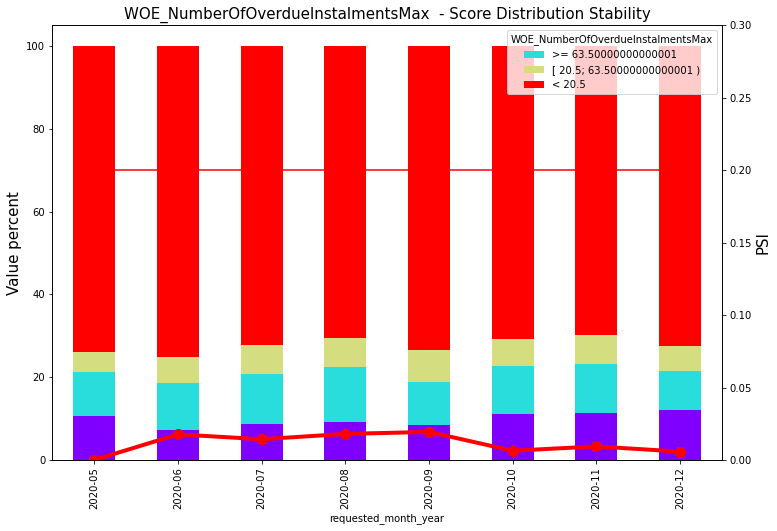

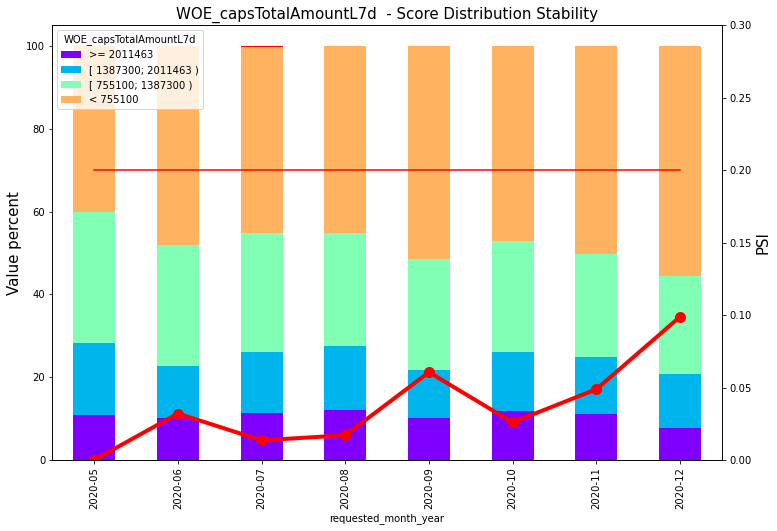

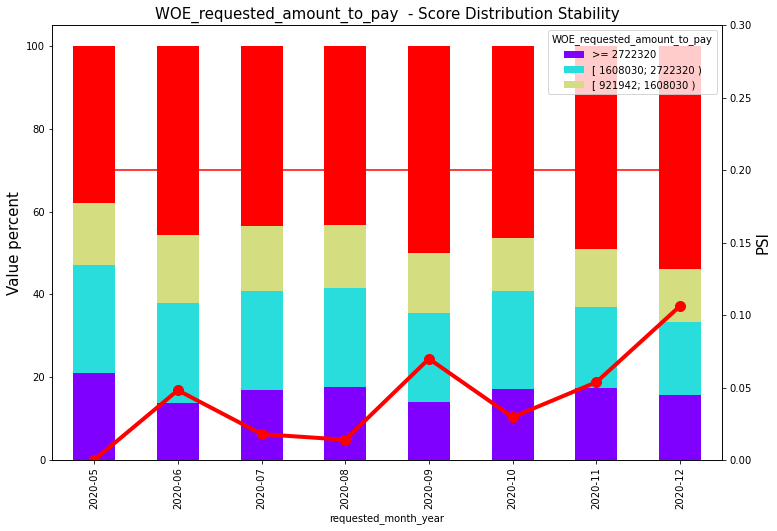

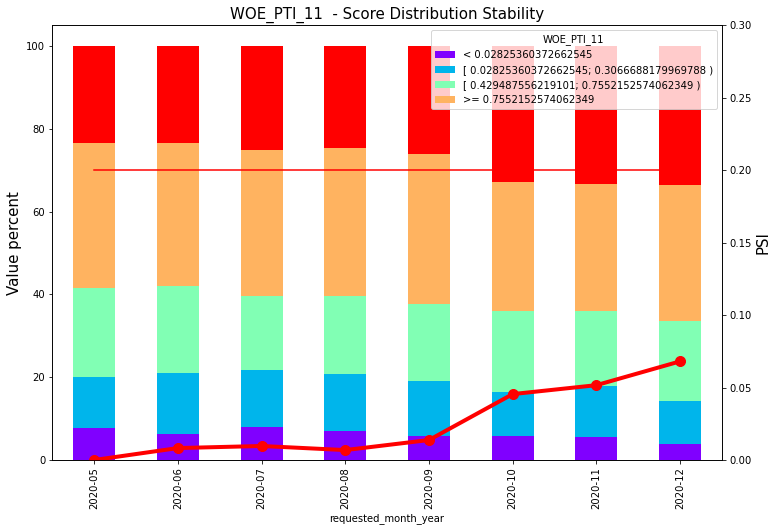

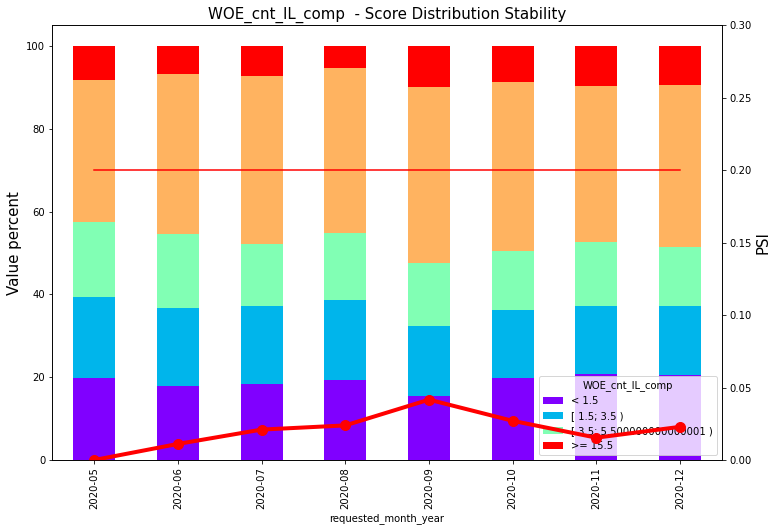

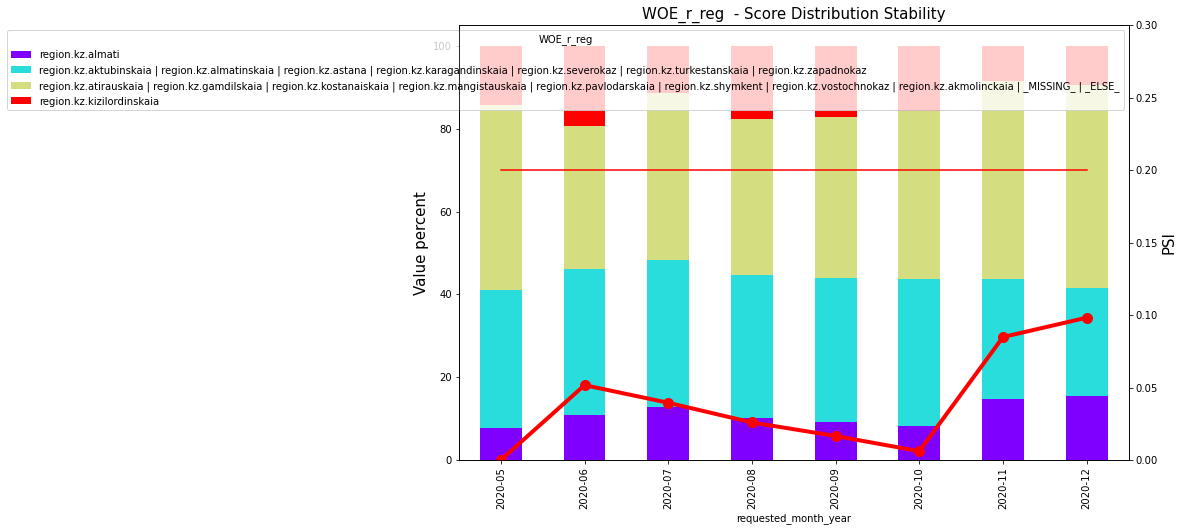

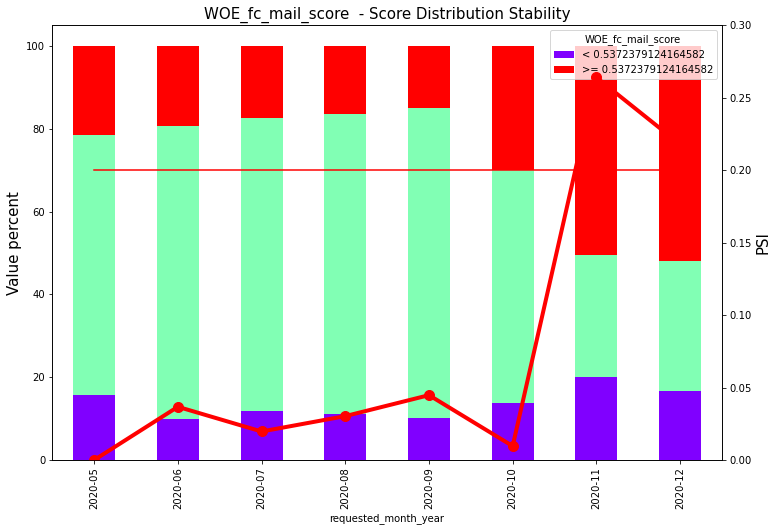

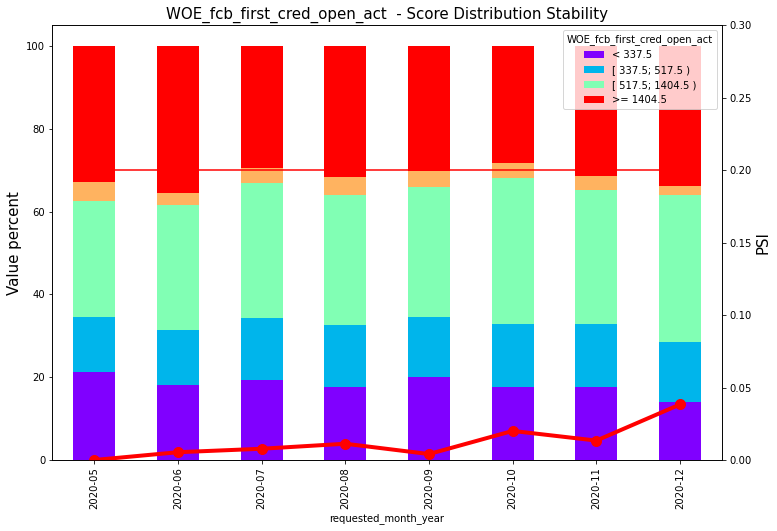

In [27]:
month_num = 0  # Номер месяца от которого отталкиваться в расчёте psi.
date_name = 'date_requested'  # имя столбца даты по которому делить на месяцы
features_of_model = population_stability(df3, ivs, feat, month_num=month_num, pic_folder=pic_folder, date_name=date_name)

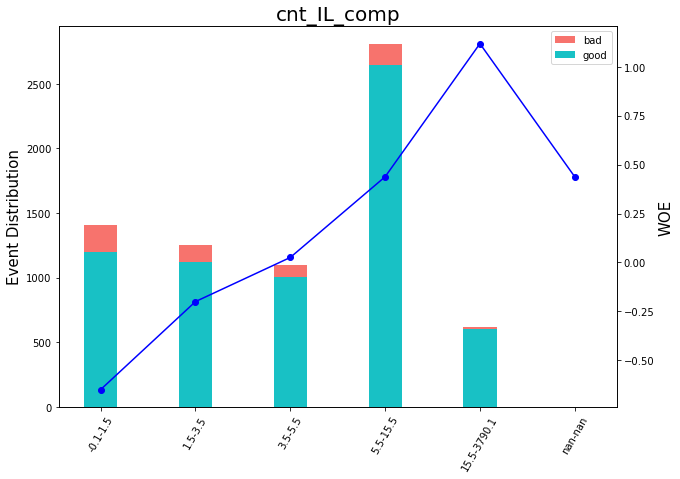

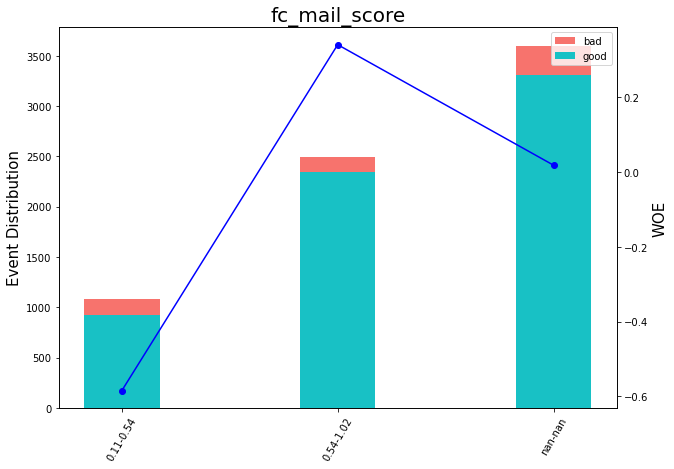

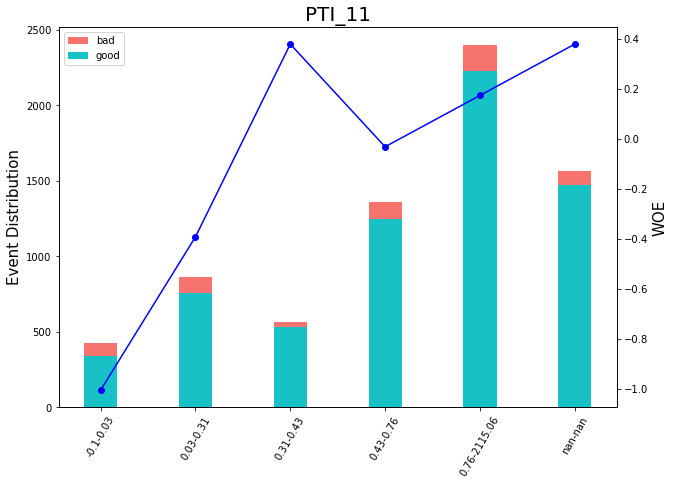

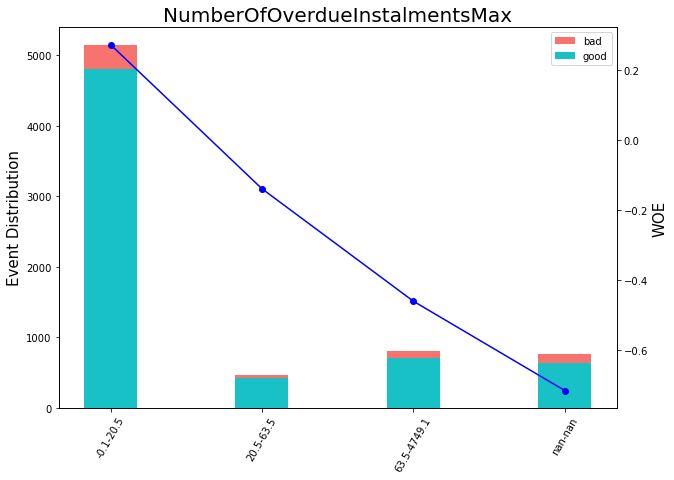

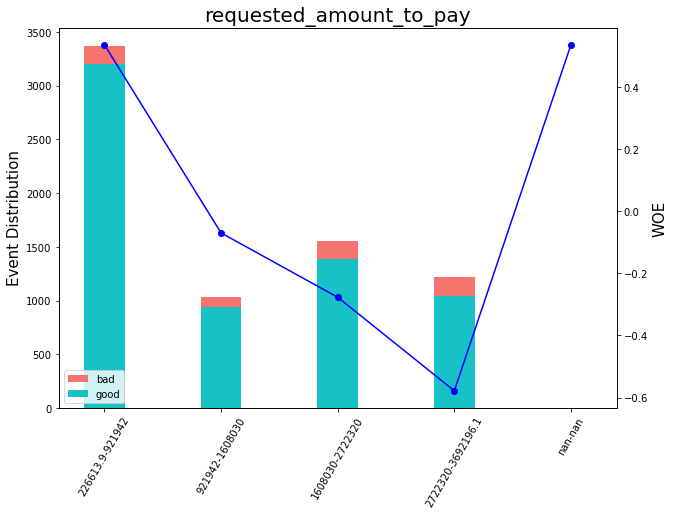

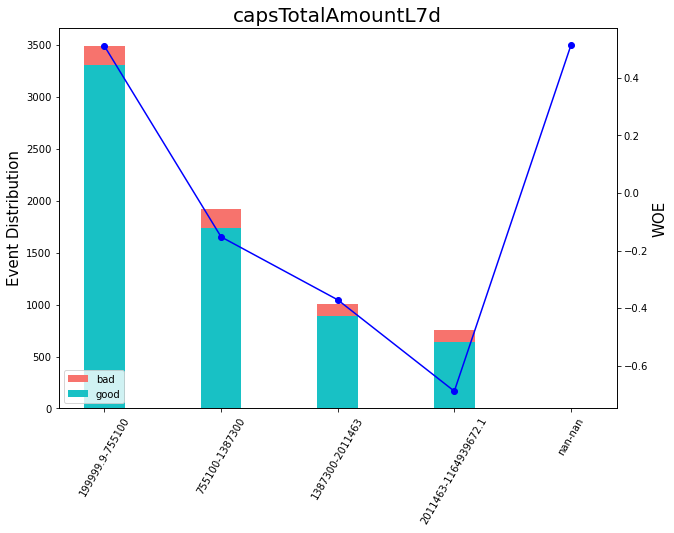

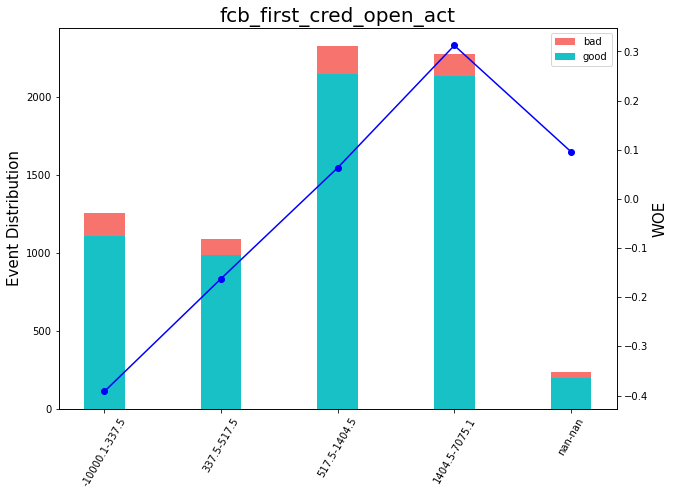

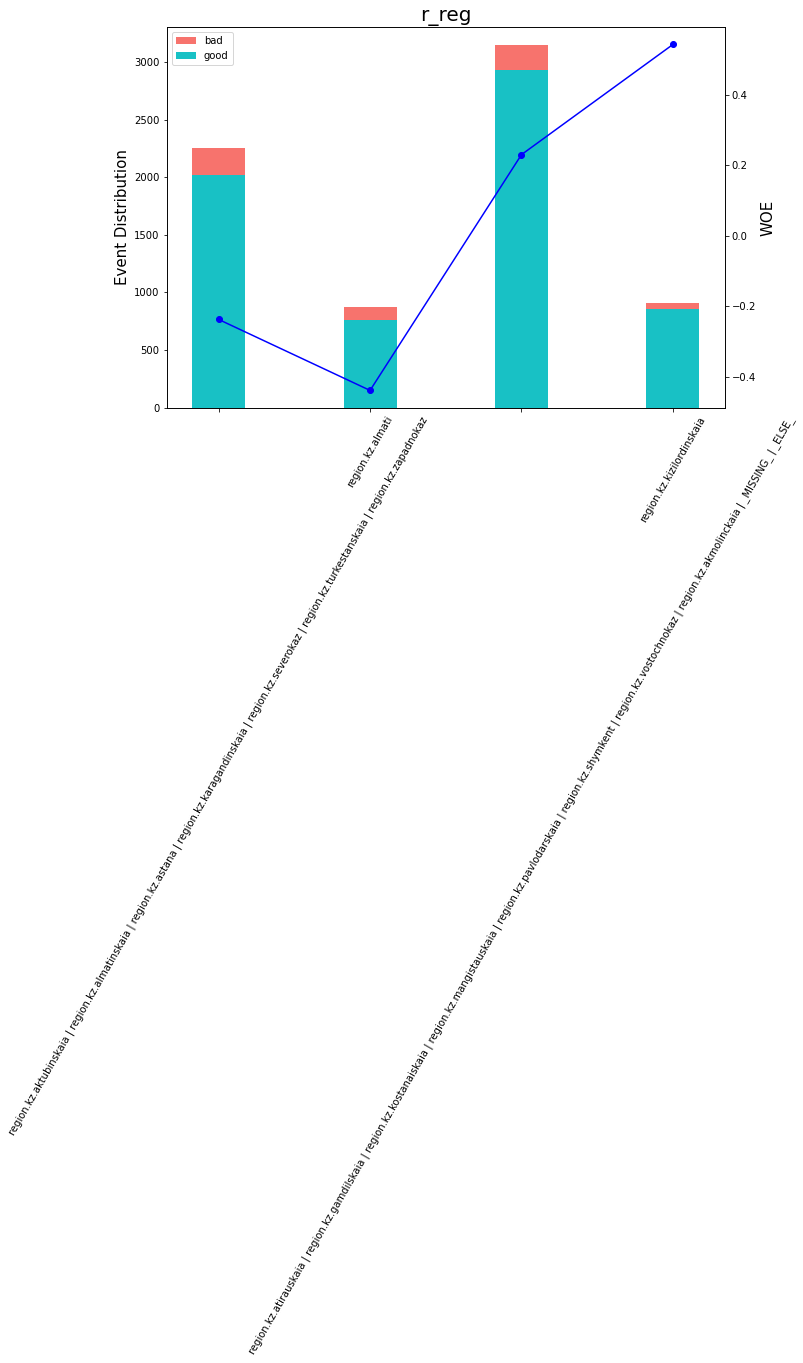

In [28]:
plot_all_bins(iv_df, X_train[vars_woe], pic_folder=pic_folder)

In [30]:
model = sm.Logit(y_train, X_train[vars_woe])
model_fit = model.fit()
model_fit.pvalues

PV = pd.DataFrame(data=model_fit.pvalues, columns=['pv_train'])
PV = PV.sort_values(by='pv_train', ascending=False)
# PV.to_excel('results/pvalues.xlsx')

Optimization terminated successfully.
         Current function value: 0.600437
         Iterations 5


In [31]:
target_description = 'npl1_3mob'
model_description = 'Скоркарта Solva KZ сегмента street'

DSL = generate_DSL(ivs, feat, nan_to_woe='max_cat', else_to_woe='max_cat')
SQL = generate_SQL(ivs, feat, nan_to_woe='max_cat', else_to_woe='max_cat')
SQL = SQL.replace('+ --', '+ ')

clf_lr = logreg
name_2 = 'report/slkz_solvaStreet_score_v1.2'

export_to_excel(
    DSL=DSL,
    SQL=SQL,
    X_train=X_train[vars_woe],
    X_test=X_test[vars_woe],
    y_train=y_train,
    y_test=y_test,
    y=y,
    df3=df3,
    iv_df=iv_df,
    ivs=ivs,
    Ginis=Ginis,
    table=table,
    scores=scores,
    feat=feat,
    features_of_model=features_of_model,
    clf_lr=clf_lr,
    gini_by_vars=gini_by_vars,
    PV=PV,
    X_out=X_out[vars_woe],
    y_out=y_out,
    name=name_2,
    pic_folder='pic/',
    target_description=target_description,
    model_description=model_description
)

Exported!
